<div>
    <h1 id = "title"
        style = "background-color: #2788f9;
                 border-radius: 9px;
                 border-left:15px #1e3772 solid;
                 color: #f8f8f8;
                 line-height: 34px;
                 padding: 15px 0px 15px 20px; 
                 font-size: 28px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">Chinese License Plate Recognition [YOLOv8 + CnOCR]
        <a class="anchor-link" id="title" href="chinese-license-plate-recognition-yolov8-cnocr#title">¶</a>
    </h1>
</div>

<div>
    <h1 id = "preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">1. Preparation
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#preparation">¶</a>
    </h1>
</div>

In [1]:
# 1.Prparation
# Import Libraries
# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
from numba import cuda

In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

from pathlib import Path

list_sub = ['ccpd_green']
splits = ['train', 'val', 'test']

PROJECT_ROOT = Path.cwd()
BASE_PATH = PROJECT_ROOT / 'ccpd_green'
YOLO_DATASET_DIR = PROJECT_ROOT / 'datasets' / 'ccpd_green_yolo'


<div class="alert alert-block alert-info" style="color: black; font-size: 15px; font-family: Trebuchet MS">
    <b>Sub Datasets</b>:
    <ul>
        <li><b>CCPD-Base</b>: The only common feature of these photos is the inclusion of a license plate</li>
        <li><b>CCPD-FN</b>: The distance from the LP to the shooting location is relatively far or near</li>
        <li><b>CCPD-DB</b>: Illuminations on the LP area are dark, uneven or extremely bright</li>
        <li><b>CCPD-Rotate</b>: Great horizontal tilt degree (20◦
 50◦) and the vertical tilt degree varies from -10◦ to 10</li>
        <li><b>CCPD-Weather</b>: Images taken on a rainy day, snow day or fog day</li>
        <li><b>CCPD-Blur</b>: Blurry largely due to hand jitter while taking pictures</li>
    </ul>
</div>

<div>
    <h1 id = "data-exploration"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2. Data Exploration
        <a class="anchor-link" id="data-exploration" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#data-exploration">¶</a>
    </h1>
</div>

<div>
    <h2 id = "sample-images"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.1. Sample Images
    </h2>
</div>

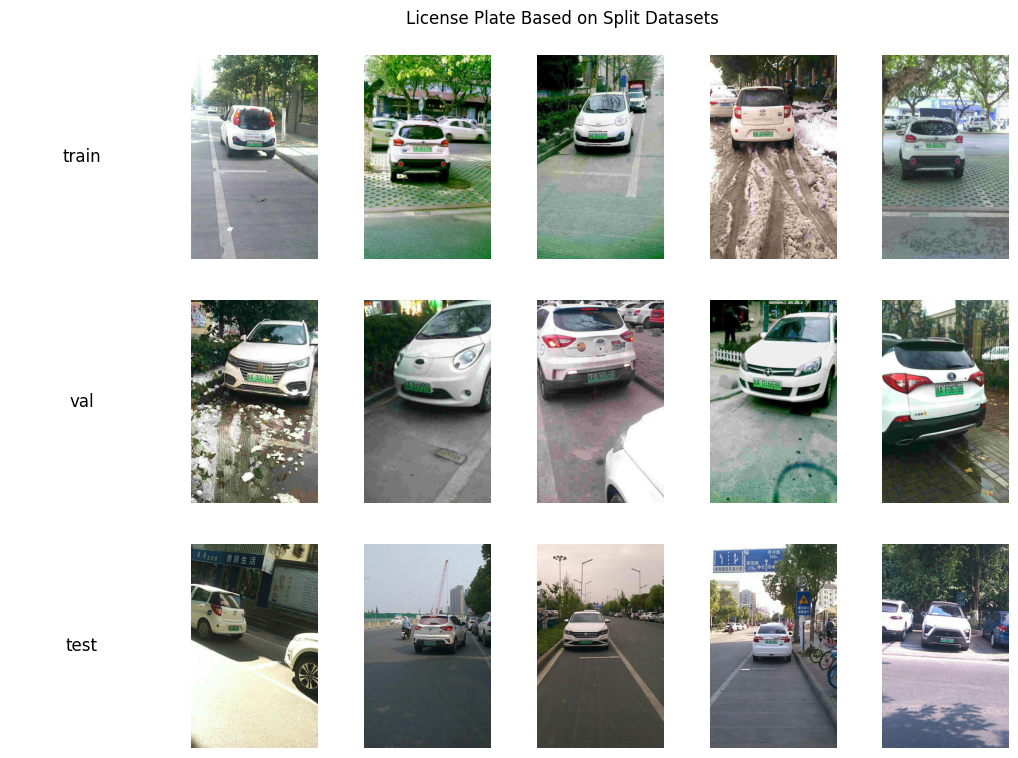

In [3]:
# 2.Data-Exploration
# 2.1 Sample Images
# Sample Images
rows = len(splits)
fig, axs = plt.subplots(rows, 6, figsize=(13, 3*rows))
axs = np.atleast_2d(axs)

for i, split in enumerate(splits):    
    axs[i, 0].text(0.5, 0.5, split, ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off')
    
    sub_path = BASE_PATH / split
    sub_files = sorted(sub_path.glob('*.jpg'))[:5]
    
    for j, file_path in enumerate(sub_files):
        image = cv2.imread(str(file_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i, j+1].imshow(image)
        axs[i, j+1].axis("off")

plt.suptitle("License Plate Based on Split Datasets", x=0.55, y=0.93)
plt.show()


<div>
    <h2 id = "image-description"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.2. Image Description
    </h2>
</div>

Split: train -> /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/train
File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/train/00360785590278-91_265-311&485_406&524-406&524_313&520_311&485_402&489-0_0_3_24_28_24_31_33-117-16.jpg
Area Ratio: 00360785590278
Tilt Degrees
-  Horizontal: 91
-  Vertical  : 265
Bounding Box
-  Left-Up     : 311&485
-  Right-Bottom: 406&524
Vertices
-  Right-Bottom: 406&524
-  Left-Bottom : 313&520
-  Left-Up     : 311&485
-  Right-Up    : 402&489
License Plate Number: 皖A D04079
Brightness: 117
Blurriness: 16


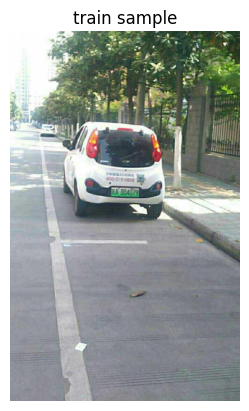

File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/train/00373372395833-90_96-276&514_387&548-387&548_276&547_276&516_384&514-0_0_3_26_25_31_33_32-157-19.jpg
Area Ratio: 00373372395833
Tilt Degrees
-  Horizontal: 90
-  Vertical  : 96
Bounding Box
-  Left-Up     : 276&514
-  Right-Bottom: 387&548
Vertices
-  Right-Bottom: 387&548
-  Left-Bottom : 276&547
-  Left-Up     : 276&516
-  Right-Up    : 384&514
License Plate Number: 皖A D21798
Brightness: 157
Blurriness: 19


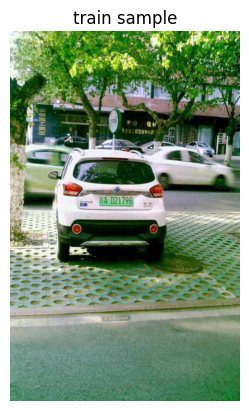


Split: val -> /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/val
File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/val/00947482638889-95_272-318&413_466&478-462&478_318&461_320&413_466&428-0_0_3_24_30_25_29_25-170-41.jpg
Area Ratio: 00947482638889
Tilt Degrees
-  Horizontal: 95
-  Vertical  : 272
Bounding Box
-  Left-Up     : 318&413
-  Right-Bottom: 466&478
Vertices
-  Right-Bottom: 462&478
-  Left-Bottom : 318&461
-  Left-Up     : 320&413
-  Right-Up    : 466&428
License Plate Number: 皖A D06151
Brightness: 170
Blurriness: 41


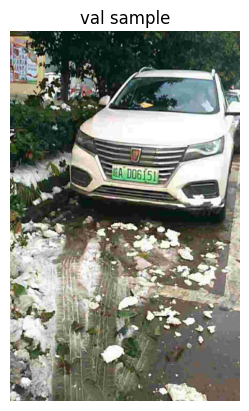

File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/val/0104275173611-93_259-224&464_379&531-379&531_230&513_224&464_375&474-0_0_3_25_33_29_29_29-75-6.jpg
Area Ratio: 0104275173611
Tilt Degrees
-  Horizontal: 93
-  Vertical  : 259
Bounding Box
-  Left-Up     : 224&464
-  Right-Bottom: 379&531
Vertices
-  Right-Bottom: 379&531
-  Left-Bottom : 230&513
-  Left-Up     : 224&464
-  Right-Up    : 375&474
License Plate Number: 皖A D19555
Brightness: 75
Blurriness: 6


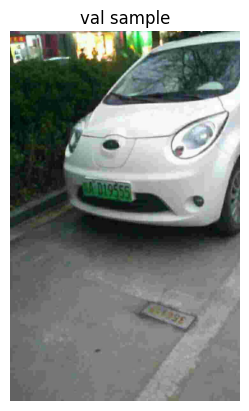


Split: test -> /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/test
File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/test/0014128352490421455-90_90-212&467_271&489-271&489_212&489_212&467_271&467-0_0_3_30_30_25_31_32-79-4.jpg
Area Ratio: 0014128352490421455
Tilt Degrees
-  Horizontal: 90
-  Vertical  : 90
Bounding Box
-  Left-Up     : 212&467
-  Right-Bottom: 271&489
Vertices
-  Right-Bottom: 271&489
-  Left-Bottom : 212&489
-  Left-Up     : 212&467
-  Right-Up    : 271&467
License Plate Number: 皖A D66178
Brightness: 79
Blurriness: 4


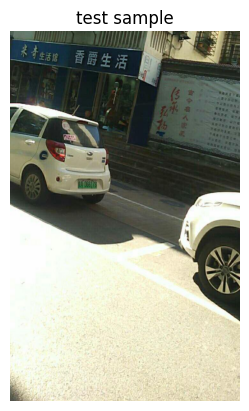

File Name: /home/shidang/py_pro/yuechuan/CCPD/ccpd_green/test/0016594827586206896-90_90-341&550_407&573-407&573_341&571_341&550_407&550-0_0_3_27_26_32_25_32-63-3.jpg
Area Ratio: 0016594827586206896
Tilt Degrees
-  Horizontal: 90
-  Vertical  : 90
Bounding Box
-  Left-Up     : 341&550
-  Right-Bottom: 407&573
Vertices
-  Right-Bottom: 407&573
-  Left-Bottom : 341&571
-  Left-Up     : 341&550
-  Right-Up    : 407&550
License Plate Number: 皖A D32818
Brightness: 63
Blurriness: 3


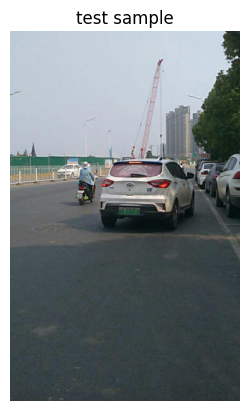

In [4]:
# 2.2 Image Description
num_files = 2

for split in splits:
    split_path = BASE_PATH / split
    print(f"Split: {split} -> {split_path}")
    split_files = sorted(split_path.glob('*.jpg'))[:num_files]

    for file_path in split_files:
        file_name = str(file_path)
        file_splitting = file_path.stem.split("-")
        print("File Name:", file_name)
        
        area_ratio = file_splitting[0]
        print("Area Ratio:", area_ratio)
        
        tilt_degrees = file_splitting[1]
        hor_tilt_degrees = tilt_degrees.split("_")[0]
        ver_tilt_degrees = tilt_degrees.split("_")[1]
        print("Tilt Degrees")
        print("-  Horizontal:", hor_tilt_degrees)
        print("-  Vertical  :", ver_tilt_degrees)
        
        bounding_box = file_splitting[2]
        left_up_bbox = bounding_box.split("_")[0]
        right_bot_bbox = bounding_box.split("_")[1]
        print("Bounding Box")
        print("-  Left-Up     :", left_up_bbox)
        print("-  Right-Bottom:", right_bot_bbox)
        
        vertices = file_splitting[3]
        right_bot_vtc = vertices.split("_")[0]
        left_bot_vtc = vertices.split("_")[1]
        left_up_vtc = vertices.split("_")[2]
        right_up_vtc = vertices.split("_")[3]
        print("Vertices")
        print("-  Right-Bottom:", right_bot_vtc)
        print("-  Left-Bottom :", left_bot_vtc)
        print("-  Left-Up     :", left_up_vtc)
        print("-  Right-Up    :", right_up_vtc)
        
        lcn = file_splitting[4]
        chi_let = provinces[int(lcn.split("_")[0])]
        alp_let = alphabets[int(lcn.split("_")[1])]
        alp_num_let = lcn.split("_")[2:]
        alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
        all_let = chi_let + alp_let + " " + alp_num_let
        print("License Plate Number:", all_let)
        
        brightness = file_splitting[5]
        print("Brightness:", brightness)
        
        blurriness = file_splitting[6]
        print("Blurriness:", blurriness)
        
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{split} sample")
        plt.axis("off")
        plt.show()
    print()


<div>
    <h2 id = "bbox-and-lpr"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">2.3. Sample Bounding Box and Exact Vertices
    </h2>
</div>

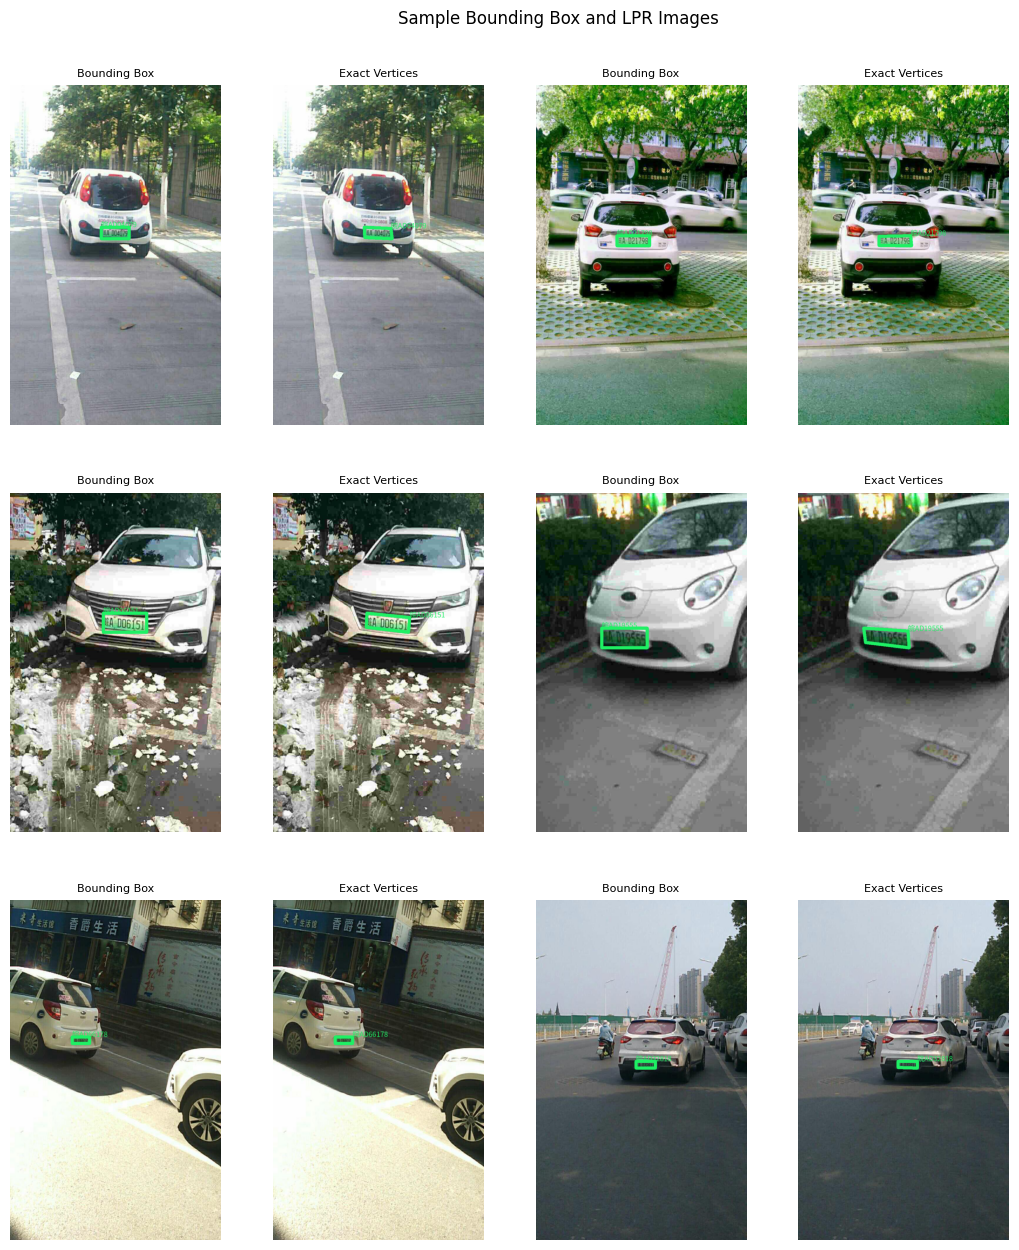

In [5]:
# 2.3. Sample Bounding Box and Exact Vertices
from PIL import Image, ImageDraw, ImageFont

FONT_PATH = "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc"
FONT = ImageFont.truetype(FONT_PATH, 24)

sample_per_split = 2

ccpd_files = []
for split in splits:
    split_path = BASE_PATH / split
    split_files = sorted(split_path.glob('*.jpg'))[:sample_per_split]
    ccpd_files.extend(split_files)

sample_files = ccpd_files[:6]

if not sample_files:
    print(f'No images found under {BASE_PATH}')
else:
    rows = max(1, (len(sample_files)+1)//2)

    fig, axs = plt.subplots(rows, 4, figsize=(13, 5*rows))
    axs = np.atleast_2d(axs)

    for i, file_path in enumerate(sample_files):
        file_splitting = file_path.stem.split('-')
        
        lcn = file_splitting[4]
        chi_let = provinces[int(lcn.split('_')[0])]
        alp_let = alphabets[int(lcn.split('_')[1])]
        alp_num_let = lcn.split('_')[2:]
        alp_num_let = ''.join([ads[int(char)] for char in alp_num_let])
        all_let = chi_let + alp_let + alp_num_let
        
        bounding_box = file_splitting[2]
        lu_bbox = bounding_box.split('_')[0]
        x1, y1 = list(map(int, lu_bbox.split('&')))
        rb_bbox = bounding_box.split('_')[1]
        x2, y2 = list(map(int, rb_bbox.split('&')))
        
        bbox_img = cv2.imread(str(file_path))
        bbox_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (30, 240, 100), 10)
        bbox_pil = Image.fromarray(bbox_img)
        ImageDraw.Draw(bbox_pil).text((x1, max(0, y1 - 28)), all_let, font=FONT, fill=(30, 240, 100))
        bbox_img = np.array(bbox_pil)
        
        axs[i//2, (i*2)%4].imshow(bbox_img)
        axs[i//2, (i*2)%4].set_title('Bounding Box', fontsize=8)
        axs[i//2, (i*2)%4].axis('off')
        
        vertices = file_splitting[3]
        vertices_split = vertices.split('_')
        
        exver_img = cv2.imread(str(file_path))
        exver_img = cv2.cvtColor(exver_img, cv2.COLOR_BGR2RGB)
        for j in range(4):
            x1, y1 = list(map(int, vertices_split[j].split('&')))
            x2, y2 = list(map(int, vertices_split[(j+1)%4].split('&')))
            cv2.line(exver_img, (x1, y1), (x2, y2), (30, 240, 100), thickness=10)
        exver_pil = Image.fromarray(exver_img)
        ImageDraw.Draw(exver_pil).text((x1, max(0, y1 - 28)), all_let, font=FONT, fill=(30, 240, 100))
        exver_img = np.array(exver_pil)
        
        axs[i//2, (i*2+1)%4].imshow(exver_img)
        axs[i//2, (i*2+1)%4].set_title('Exact Vertices', fontsize=8)
        axs[i//2, (i*2+1)%4].axis('off')

    plt.suptitle('Sample Bounding Box and LPR Images', x=0.55, y=0.93)
    plt.show()


<div>
    <h1 id = "plate-detection"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 border-left:15px #1e3772 solid;
                 color: #1e3772;
                 line-height: 26px;
                 padding: 12px; 
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3. Plate Detection - YOLOv8
        <a class="anchor-link" id="plate-detection" href="https://www.kaggle.com/code/harits/chinese-license-plate-recognition-yolov8-cnocr#plate-detection">¶</a>
    </h1>
</div>

<div>
    <h2 id = "data-preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.1. Data Preparation
    </h2>
</div>

<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Create Metadata</h3>
</div>

In [6]:
# 3.1 Data Preparation
# Create Metadata
def extract_plate_number(plate_number):
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let

records = []
for split in splits:
    split_path = BASE_PATH / split
    for image_path in split_path.glob('*.jpg'):
        file_splitting = image_path.stem.split("-")
        bbox = file_splitting[2]
        x1_bbox = int(bbox.split("_")[0].split("&")[0])
        y1_bbox = int(bbox.split("_")[0].split("&")[1])
        x2_bbox = int(bbox.split("_")[1].split("&")[0])
        y2_bbox = int(bbox.split("_")[1].split("&")[1])
        plate_number = extract_plate_number(file_splitting[4])
        records.append({
            "image_path": str(image_path),
            "sub": list_sub[0],
            "split": split,
            "x1_bbox": x1_bbox,
            "y1_bbox": y1_bbox,
            "x2_bbox": x2_bbox,
            "y2_bbox": y2_bbox,
            "plate_number": plate_number
        })

df_metadata = pd.DataFrame(records)
df_metadata


,image_path,sub,split,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number
0,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,247,472,540,570,皖AF11777
1,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,183,484,465,564,皖AD09686
2,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,201,472,486,561,皖AD22123
3,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,220,450,413,516,皖ADT1105
4,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,203,468,494,561,皖AF07000
...,...,...,...,...,...,...,...,...
11771,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,156,511,556,606,皖AD26629
11772,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,208,485,544,565,皖AD15566
11773,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,216,580,350,627,皖AD15861
11774,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,163,513,561,617,皖AD97798


<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Create YOLOv8 Bounding Box Format</h3>
</div>

In [7]:
# Create YOLOv8 Bounding Box Format
df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2*720)
df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2*1160)

df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / 720
df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / 1160

df_metadata

,image_path,sub,split,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number,xmid,ymid,bb_width,bb_height
0,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,247,472,540,570,皖AF11777,0.546528,0.449138,0.406944,0.084483
1,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,183,484,465,564,皖AD09686,0.450000,0.451724,0.391667,0.068966
2,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,201,472,486,561,皖AD22123,0.477083,0.445259,0.395833,0.076724
3,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,220,450,413,516,皖ADT1105,0.439583,0.416379,0.268056,0.056897
4,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,train,203,468,494,561,皖AF07000,0.484028,0.443534,0.404167,0.080172
...,...,...,...,...,...,...,...,...,...,...,...,...
11771,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,156,511,556,606,皖AD26629,0.494444,0.481466,0.555556,0.081897
11772,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,208,485,544,565,皖AD15566,0.522222,0.452586,0.466667,0.068966
11773,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,216,580,350,627,皖AD15861,0.393056,0.520259,0.186111,0.040517
11774,/home/shidang/py_pro/yuechuan/CCPD/ccpd_green/...,ccpd_green,test,163,513,561,617,皖AD97798,0.502778,0.487069,0.552778,0.089655


<div>
    <h3 style = "color: #2788f9; font-size: 18px; font-family: Trebuchet MS; font-weight: bold;">Data Splitting</h3>
</div>

In [8]:
# Data Splitting
df_metadata["split"].value_counts()


split
train    5769
test     5006
val      1001
Name: count, dtype: int64

<div>
    <h2 id = "yolo-preparation"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.2. YOLOv8 Preparation
    </h2>
</div>

In [9]:
# 强制 numpy<2，防止被依赖升级
!pip install "numpy<2" --force-reinstall --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 3.2 MB/s  0:00:05m0:00:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
torchmetrics 1.8.2 requires torch>=2.0.0, but you have torch 1.13.1+cu116 which is incompatible.


In [10]:
# 确保 numpy 版本 <2，避免自动升级
!pip install "numpy<2" --upgrade --upgrade-strategy only-if-needed


In [11]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics --upgrade-strategy only-if-needed --no-deps
!pip install --upgrade-strategy only-if-needed --no-cache-dir -r ultralytics/requirements.txt


fatal: 目标路径 'ultralytics' 已经存在，并且不是一个空目录。
ERROR: Could not open requirements file: [Errno 2] 没有那个文件或目录: 'ultralytics/requirements.txt'


In [12]:
# 3.2 YOLOv8 Preparation
# Create Dataset Folder in YOLOv8
for split in splits:
    (YOLO_DATASET_DIR / split / "images").mkdir(parents=True, exist_ok=True)
    (YOLO_DATASET_DIR / split / "labels").mkdir(parents=True, exist_ok=True)

custom_dataset_yaml = YOLO_DATASET_DIR / "custom_dataset.yaml"


In [13]:
# https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition/notebook
# Copy Image to YOLOv8 Dataset Folder and Create Text
def image_and_text_yolo(split):
    df = df_metadata[df_metadata["split"]==split].reset_index(drop=True)
    folder_path = YOLO_DATASET_DIR / split
    img_path = folder_path / "images"
    label_path = folder_path / "labels"
    
    values = df[['image_path','xmid','ymid','bb_width','bb_height']].values
    for file_name, x, y, w, h in tqdm(values):
        image_name = os.path.split(file_name)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = img_path / image_name
        dst_label_file = label_path / f"{txt_name}.txt"

        if not dst_image_path.exists():
            try:
                os.link(file_name, dst_image_path)
            except OSError:
                shutil.copy(file_name, dst_image_path)

        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file, mode='w') as f:
            f.write(label_txt)
            f.close()
            
image_and_text_yolo("train")
print("Train Dataset Created")
image_and_text_yolo("val")
print("Val Dataset Created")
image_and_text_yolo("test")
print("Test Dataset Created")


100%|██████████| 5769/5769 [00:00<00:00, 18734.81it/s]


Train Dataset Created


100%|██████████| 1001/1001 [00:00<00:00, 18265.62it/s]


Val Dataset Created


100%|██████████| 5006/5006 [00:00<00:00, 17857.48it/s]

Test Dataset Created


In [14]:
# Create Custom Dataset Configuration
dataset_yaml = f"""
train: {YOLO_DATASET_DIR / 'train' / 'images'}
val: {YOLO_DATASET_DIR / 'val' / 'images'}
test: {YOLO_DATASET_DIR / 'test' / 'images'}
    
nc: 1
    
names: [
    'license_plate'
]
"""
custom_dataset_yaml.write_text(dataset_yaml)
print(f"Dataset yaml saved to {custom_dataset_yaml}")


Dataset yaml saved to /home/shidang/py_pro/yuechuan/CCPD/datasets/ccpd_green_yolo/custom_dataset.yaml


<div>
    <h2 id = "yolo-training"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.3. YOLOv8 Training
    </h2>
</div>

In [15]:
#3.3 YOLOv8 Training
try:
    import torch
    import GPUtil
    from GPUtil import showUtilization as gpu_usage
    from numba import cuda
except ImportError:
    torch = None

if torch is None or not torch.cuda.is_available():
    print('未检测到可用 GPU，跳过清理')
else:
    print('Initial GPU Usage')
    gpu_usage()
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
    print('GPU Usage after emptying the cache')
    gpu_usage()


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  5% |  4% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  8% |  5% |


In [16]:
import os
from pathlib import Path
import torch
from ultralytics import YOLO

custom_dataset_yaml = Path("datasets/ccpd_green_yolo/custom_dataset.yaml")
assert custom_dataset_yaml.exists(), f"{custom_dataset_yaml} 不存在"

os.environ.pop("CUDA_VISIBLE_DEVICES", None)

_device = 0 if torch.cuda.is_available() else "cpu"
print(f"Using device={_device} for training")

model = YOLO("yolov8s.pt")
model.train(
    data=str(custom_dataset_yaml),
    epochs=25,
    verbose=True,
    batch=32,
    project="runs/detect",
    name="train",
    exist_ok=True,
    device=_device,
)


Using device=0 for training
Ultralytics 8.3.240 🚀 Python-3.9.23 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 4090, 24058MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/ccpd_green_yolo/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=F

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x77c21c6ecfa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

<div>
    <h2 id = "quick-sanity-check"
        style = "background-color: #9dd6fb;
                 border-radius: 15px;
                 color: #1e3772;
                 line-height: 20px;
                 padding: 11px; 
                 font-size: 20px;
                 font-weight: bold;
                 font-family: Trebuchet MS;">3.4 Quick Sanity Check on car_1 / car_2
    </h2>
</div>


car_1.png: 皖AD15129


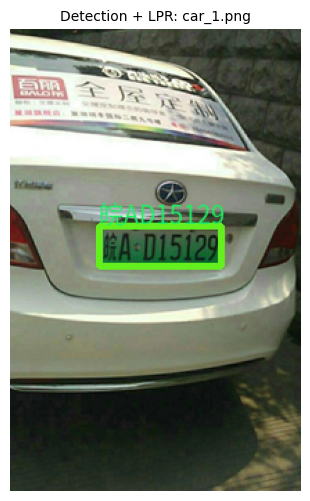

car_2.png: 皖AD07086


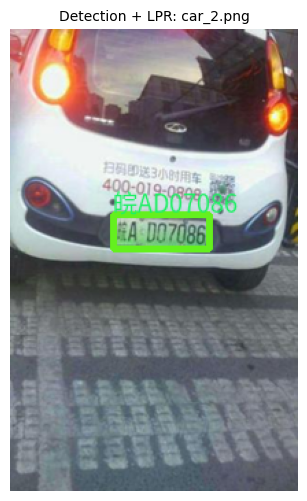

In [17]:
# 3.4 Quick Sanity Check on car_1 / car_2
# Perform detection and background removal (cut-out) on car_1.png and car_2.png, and output the OCR results.
from pathlib import Path
import re
import cv2
import torch
from ultralytics import YOLO
from rapidocr_onnxruntime import RapidOCR
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
PROJECT_ROOT = PROJECT_ROOT if 'PROJECT_ROOT' in globals() else Path.cwd()
CROP_DIR = PROJECT_ROOT / 'extra_crops'
CROP_DIR.mkdir(exist_ok=True)

FONT_PATH = "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc"
FONT = ImageFont.truetype(FONT_PATH, 18)

def expand_bbox(box, img_shape, pad_ratio=0.2, min_pad=10):
    h, w = img_shape[:2]
    x1, y1, x2, y2 = [int(v) for v in box]
    bw, bh = x2 - x1, y2 - y1
    pad_x = max(min_pad, int(bw * pad_ratio))
    pad_y = max(min_pad, int(bh * pad_ratio))
    return max(0, x1-pad_x), max(0, y1-pad_y), min(w, x2+pad_x), min(h, y2+pad_y)

def clean_full(text_output):
    if not text_output:
        return ''
    parts = []
    for seg in text_output:
        if len(seg) > 1:
            val = seg[1]
            if isinstance(val, (list, tuple)):
                val = val[0] if val else ''
            parts.append(str(val))
    full = ''.join(parts)
    full = re.sub(r"[ ·:-]", "", full).replace('O','0').replace('I','1').upper()
    return full

def predict_plate(img_path):
    if not img_path.exists():
        print(f"{img_path.name}: 文件不存在")
        return
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"{img_path.name}: 无法读取图像")
        return
    yolo_model = YOLO('runs/detect/train/weights/best.pt')
    try:
        result = yolo_model.predict(str(img_path), verbose=False, device=_device)[0]
    except Exception as e:
        print(f"{img_path.name}: 预测出错 {e}")
        return
    if len(result.boxes)==0:
        print(f"{img_path.name}: 未检测到车牌")
        return
    ocr = RapidOCR()
    texts=[]
    crops_saved = 0
    vis_img = img.copy()
    for idx, box in enumerate(result.boxes):
        bx1, by1, bx2, by2 = [int(v) for v in box.xyxy[0].tolist()]
        cv2.rectangle(vis_img, (bx1, by1), (bx2, by2), (30, 240, 100), 4)
        x1,y1,x2,y2=expand_bbox(box.xyxy[0].tolist(), img.shape)
        crop = img[y1:y2, x1:x2]
        if crop.size==0:
            continue
        crop_path = CROP_DIR / f"{img_path.stem}_crop{idx+1}.png"
        cv2.imwrite(str(crop_path), crop)
        crops_saved += 1
        text_output, _ = ocr(crop)
        cleaned = clean_full(text_output)
        if cleaned:
            texts.append(cleaned)
        label = cleaned if cleaned else "N/A"
        vis_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(vis_rgb)
        draw = ImageDraw.Draw(pil_img)
        draw.text((bx1, max(0, by1 - 22)), label, font=FONT, fill=(30, 240, 100))
        vis_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    final_text = texts[0] if texts else ''
    print(f"{img_path.name}: {final_text}")
    rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb)
    plt.title(f"Detection + LPR: {img_path.name}", fontsize=10)
    plt.axis("off")
    plt.show()

for name in ['car_1.png','car_2.png']:
    predict_plate(PROJECT_ROOT / name)


